In [10]:
# Simple CNN Training Pipeline (acc_score >= 80)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

DATA_PATH = r"d:\Code\Lychee\lychee-meal-planners\systems\dataset\training_data\deap_training_backup_500_samples.csv"
df = pd.read_csv(DATA_PATH)

In [23]:
y = ((df['overall_score'] + 3 * df['critical_score'])/4 > 80).astype(int).values
X = df[[c for c in ['pop_size', 'n_gen', 'cxpb', 'mutpb'] if c in df.columns]].values

In [29]:
# Print all data rows where y == 1 (positive class), sorted by exec_time
positive_mask = (y == 1)
positive_df = df[positive_mask]
if 'exec_time' in positive_df.columns:
    positive_df = positive_df.sort_values('exec_time')
print(f"Total positive samples (y=1): {len(positive_df)}")
display(positive_df)

Total positive samples (y=1): 29


,pop_size,n_gen,cxpb,mutpb,overall_score,critical_score,num_foods,exec_time
490,87,85,0.821274,0.355679,72.5,86.666667,8,13.456387
89,63,61,0.781791,0.369318,65.0,93.333333,7,16.603926
224,78,64,0.859459,0.359967,77.5,86.666667,7,20.207931
20,63,73,0.778976,0.417395,85.0,93.333333,8,25.651264
201,55,75,0.853556,0.334916,80.0,93.333333,7,27.184862
173,73,70,0.733787,0.411436,62.5,86.666667,8,27.501789
118,85,68,0.798605,0.333314,75.0,93.333333,7,30.364593
159,57,99,0.870436,0.520763,82.5,86.666667,8,30.812236
214,68,81,0.792536,0.420551,77.5,86.666667,8,32.487980
375,88,91,0.733497,0.341827,77.5,86.666667,7,34.933000


Text(0.5, 0, 'Critical Score')

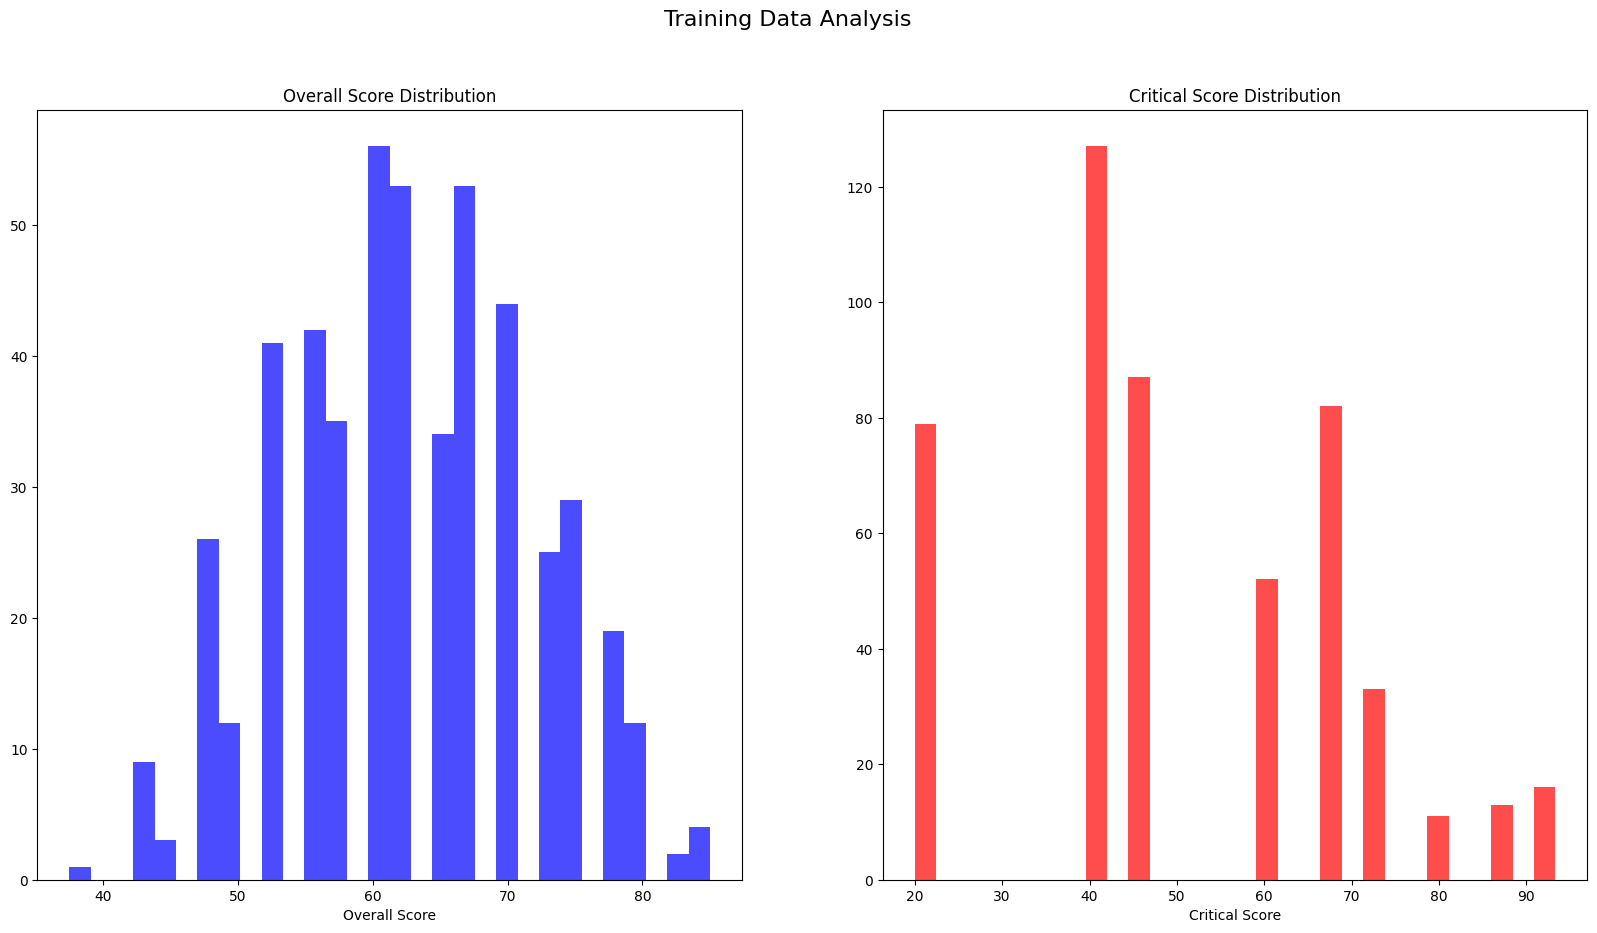

In [22]:
# Visualize training data
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Training Data Analysis', fontsize=16)

# Score distributions
axes[0].hist(df['overall_score'], bins=30, alpha=0.7, color='blue')
axes[0].set_title('Overall Score Distribution')
axes[0].set_xlabel('Overall Score')

axes[1].hist(df['critical_score'], bins=30, alpha=0.7, color='red')
axes[1].set_title('Critical Score Distribution')
axes[1].set_xlabel('Critical Score')

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
X_val_cnn = X_val.reshape(-1, X_val.shape[1], 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

# Simple CNN model
def build_minimal_cnn(input_shape):
    model = keras.Sequential([
        layers.Conv1D(4, 2, activation='relu', input_shape=input_shape),
        layers.GlobalMaxPooling1D(),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn = build_minimal_cnn(X_train_cnn.shape[1:])

# Train
history = cnn.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=25,
    batch_size=32,
    verbose=2
)

# Evaluate
val_loss, val_acc = cnn.evaluate(X_val_cnn, y_val, verbose=0)
test_loss, test_acc = cnn.evaluate(X_test_cnn, y_test, verbose=0)

print(f"Validation Accuracy: {val_acc*100:.2f}%, Validation Loss: {val_loss:.2f}")
print(f"Test Accuracy: {test_acc*100:.2f}%, Test Loss: {test_loss:.2f}")

Epoch 1/25
11/11 - 1s - loss: 0.4584 - accuracy: 0.9429 - val_loss: 0.4571 - val_accuracy: 0.9333 - 855ms/epoch - 78ms/step
Epoch 2/25
11/11 - 1s - loss: 0.4584 - accuracy: 0.9429 - val_loss: 0.4571 - val_accuracy: 0.9333 - 855ms/epoch - 78ms/step
Epoch 2/25
11/11 - 0s - loss: 0.4408 - accuracy: 0.9429 - val_loss: 0.4411 - val_accuracy: 0.9333 - 55ms/epoch - 5ms/step
Epoch 3/25
11/11 - 0s - loss: 0.4408 - accuracy: 0.9429 - val_loss: 0.4411 - val_accuracy: 0.9333 - 55ms/epoch - 5ms/step
Epoch 3/25
11/11 - 0s - loss: 0.4248 - accuracy: 0.9429 - val_loss: 0.4257 - val_accuracy: 0.9333 - 53ms/epoch - 5ms/step
Epoch 4/25
11/11 - 0s - loss: 0.4248 - accuracy: 0.9429 - val_loss: 0.4257 - val_accuracy: 0.9333 - 53ms/epoch - 5ms/step
Epoch 4/25
11/11 - 0s - loss: 0.4090 - accuracy: 0.9429 - val_loss: 0.4117 - val_accuracy: 0.9333 - 53ms/epoch - 5ms/step
Epoch 5/25
11/11 - 0s - loss: 0.4090 - accuracy: 0.9429 - val_loss: 0.4117 - val_accuracy: 0.9333 - 53ms/epoch - 5ms/step
Epoch 5/25
11/11 - 0

In [8]:
# Print CNN model structure
print('CNN Model Structure:')
cnn.summary()

CNN Model Structure:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 3, 4)              12        
                                                                 
 global_max_pooling1d_2 (Gl  (None, 4)                 0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 3, 4)              12        
                                                                 
 global_max_pooling1d_2 (Gl  (None, 4)                 0         
 obalMaxPooling1D)               

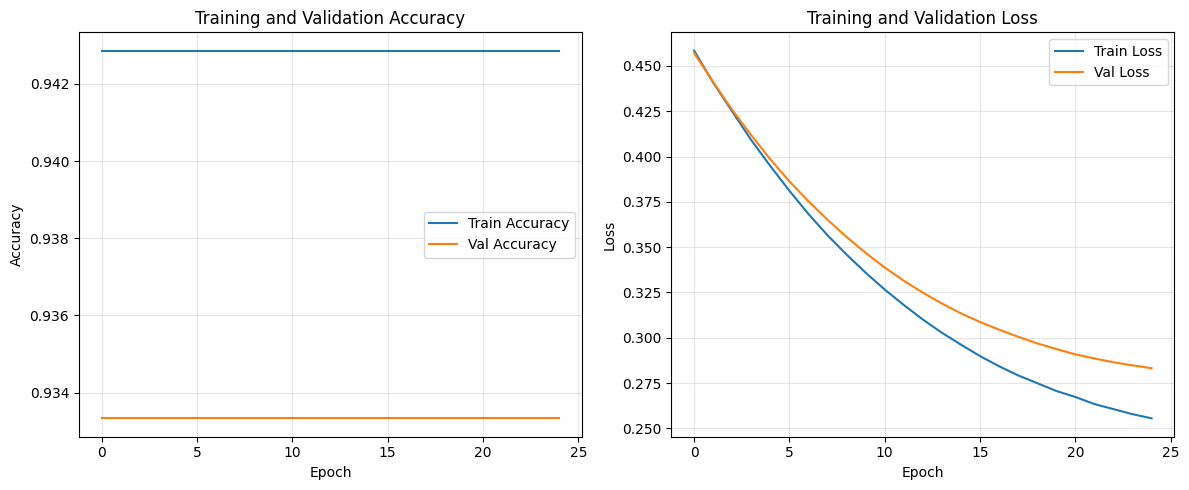

In [19]:
# Visualization: Training and Validation Curves
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()